# Librerías

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm 
from scipy import sparse
import seaborn as sns
import scanpy as sc 
from matplotlib import pyplot as plt

# Lectura

In [4]:
parietal00 = pd.read_csv('../data/00-filt_counts/00-filtered_feature_bc_matrix010_parietal_filt_counts.csv').drop('Unnamed: 0', axis = 1)
parietal01 = pd.read_csv('../data/01-filt_counts/01-filtered_feature_bc_matrix010_parietal_filt_counts.csv').drop('Unnamed: 0', axis = 1)

frontal00 = pd.read_csv('../data/00-filt_counts/00-filtered_feature_bc_matrix010_frontal_filt_counts.csv').drop('Unnamed: 0', axis = 1)
frontal01 = pd.read_csv('../data/01-filt_counts/01-filtered_feature_bc_matrix010_frontal_filt_counts.csv').drop('Unnamed: 0', axis = 1)

In [5]:
parietal00 = sparse.csr_matrix(parietal00)
parietal01 = sparse.csr_matrix(parietal01)

frontal00 = sparse.csr_matrix(frontal00)
frontal01 = sparse.csr_matrix(frontal01)

# Histograma de conteos

  0%|          | 0/4 [00:00<?, ?it/s]

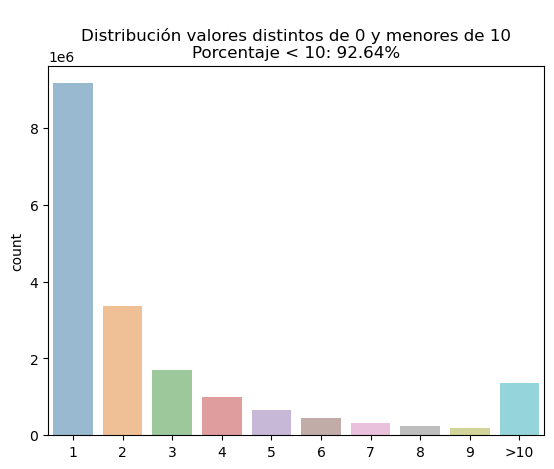

 25%|██▌       | 1/4 [08:07<24:23, 487.85s/it]

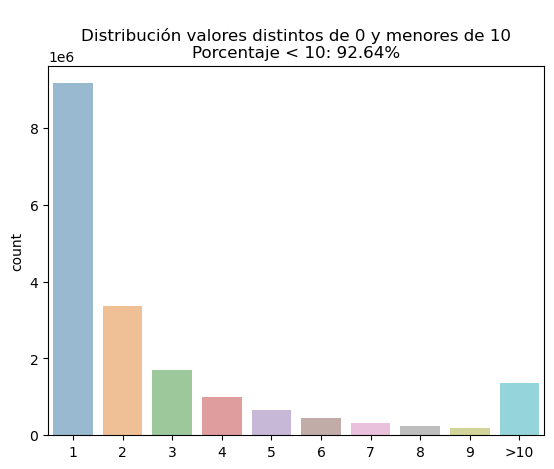

 50%|█████     | 2/4 [20:37<21:24, 642.10s/it]

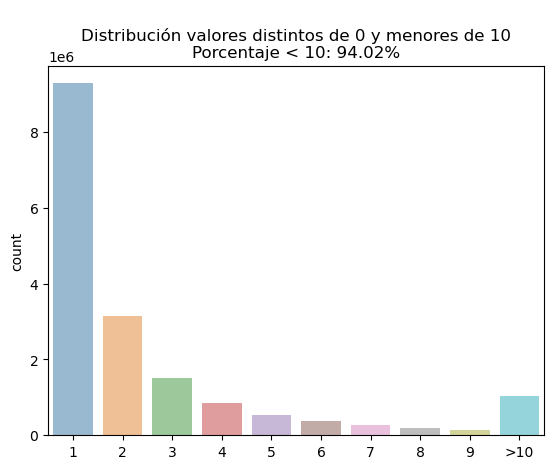

 75%|███████▌  | 3/4 [28:41<09:29, 569.79s/it]

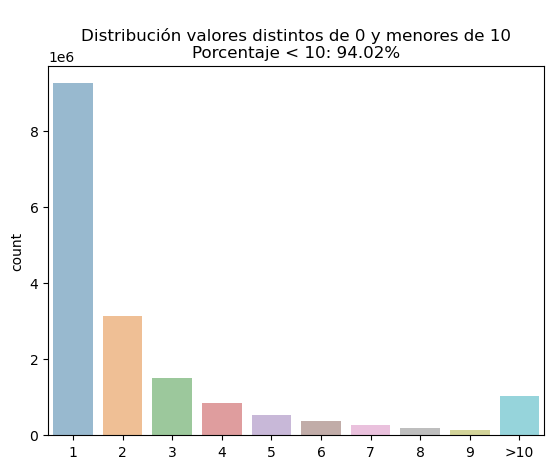

100%|██████████| 4/4 [36:58<00:00, 554.70s/it]


In [ ]:
# Histograma conteos
for sparse_mat in tqdm([parietal00, parietal01, frontal00, frontal01]):
    nonzero_values = sparse_mat.nonzero()
    nonzero_values = np.array([sparse_mat[i,j] for (i,j) in zip(nonzero_values[0],nonzero_values[1])])
    
    porcentaje_men_10 = round(len(nonzero_values[nonzero_values<10])/len(nonzero_values)*100,2)

    nonzero_values = np.where(nonzero_values >= 10, '>10', nonzero_values)
    nonzero_values.sort()

    sns.countplot(x = nonzero_values, alpha = 0.5).set(
        title = f'\nDistribución valores distintos de 0 y menores de 10\nPorcentaje < 10: {porcentaje_men_10}%')
    plt.show()

# Por gen

In [17]:
parietal00.shape

(36601, 4934)

In [18]:
adata_dict = {}
for key, item in zip(['parietal00', 'parietal01', 'frontal00', 'frontal01'], 
                [parietal00, parietal01, frontal00, frontal01]):
    x = item.todense().T

    adata = sc.AnnData(x)

    adata_dict[key] = adata

C:\Users\melir\AppData\Local\Temp\ipykernel_12808\3618394622.py:6: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(x)
C:\Users\melir\AppData\Local\Temp\ipykernel_12808\3618394622.py:6: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(x)
C:\Users\melir\AppData\Local\Temp\ipykernel_12808\3618394622.py:6: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = 

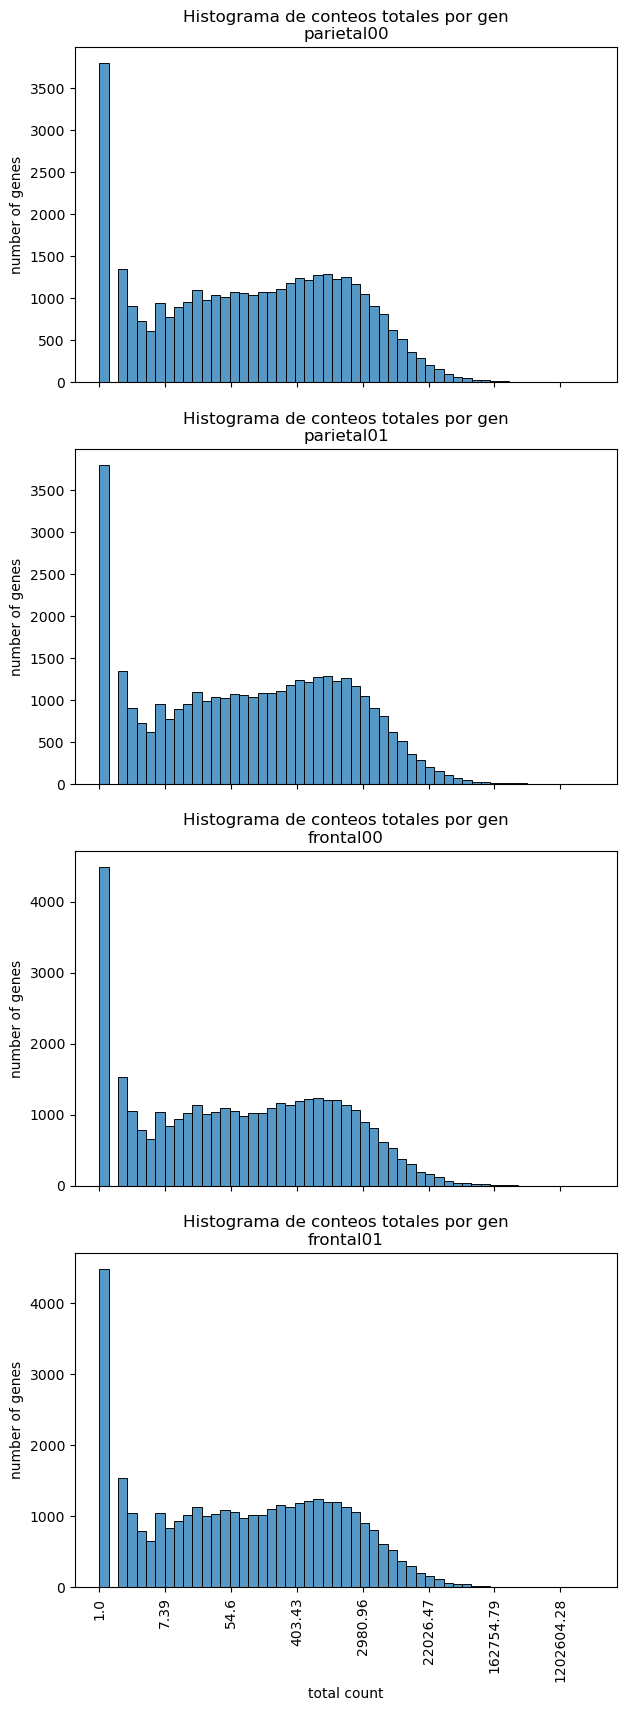

In [22]:
# Histograma de conteos por gen

fig, axes = plt.subplots(nrows = 4, sharex = True, figsize = (7,20))

for ax, (key, adata) in zip(axes, adata_dict.items()):
    sc.pp.calculate_qc_metrics(adata, inplace=True)

    p = sns.histplot(
        x=adata.var.log1p_total_counts,
        ax = ax        
    ).set(xlabel = 'total count', ylabel = 'number of genes')
    ax.set_title(f'Histograma de conteos totales por gen\n{key}')

def custom_xtick_label_formatter(x, pos):
    return round(np.exp(float(x)),2)

axes[-1].xaxis.set_major_formatter(plt.FuncFormatter(custom_xtick_label_formatter))

axes[-1].tick_params(axis='x', rotation=90)

In [31]:
def heat_map_gen(df, dataset_name):
    mat_heatmap = []

    sparse_mat = sparse.csr_matrix(df.X)

    print('Se pasó a sparse')

    # Itero sobre los genes
    for gene in tqdm(range(sparse_mat.shape[1])):
        gene_info = np.array(sparse_mat[:,gene].todense().flatten())[0]

        # Quitamos 0's
        gene_info = gene_info[gene_info > 0]

        # Cambiamos los mayores a 10 por 10
        gene_info = np.where(gene_info > 10, 10, gene_info)
        gene_info.sort()

        unique, counts = np.unique(gene_info, return_counts=True)
        
        all_values = np.arange(1, 11)
        all_counts = np.zeros_like(all_values)
        indices = np.searchsorted(all_values, unique)

        all_counts[indices] = counts

        mat_heatmap.append(all_counts)

    sns.heatmap(mat_heatmap,cmap='RdBu_r',center=0)
    plt.title(f'Heatmap de conteos por gen \n{dataset_name}')

Se pasó a sparse


100%|██████████| 36601/36601 [16:57<00:00, 35.97it/s]


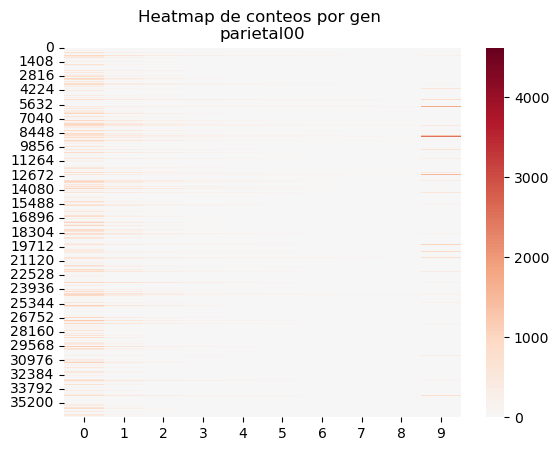

Se pasó a sparse


100%|██████████| 36601/36601 [14:10<00:00, 43.05it/s]


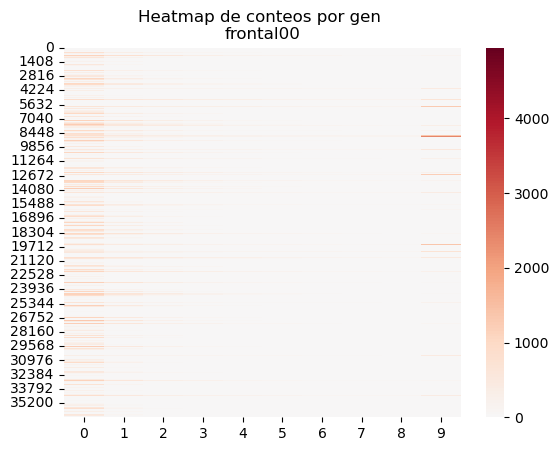

In [32]:
# Histograma conteos por gen

for k, df in adata_dict.items():
    if '00' in k:
        heat_map_gen(df,k)
        plt.show()